# AB Testing Course - PA Bond

In [3]:
import pandas as pd
import numpy as np
import math
from statsmodels.stats import api as sms
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp,shapiro,ttest_ind,mannwhitneyu,f_oneway,chi2_contingency
import seaborn as sns
from matplotlib            import pyplot as plt
import pingouin as pg

## 0.0 Planejamento

## 1.0 Design do Experimento

In [4]:
# Imagina que o experimento ainda não aconteceu, então desenhamos ele como deveria acontecer

# Objetivo: Definir se o preenchumento automático da página de checkout é melhor do que o preenchimento manual
# Para escolher a métrica de sucesso é interessante trabalhar com algo que não apresenta um alto desvio padrão, pois isso pode influenciar no tamanho da amostra que precisa, o melhor é trabalhar com a conversão, se não tem, o número de compra e por fim o faturamento
# Métrica com dispersão naturalmente menor
# Conversão - (0 - 1)
# Compras - (0 - Unidades)
# GMV - (0 - Valor)
# Métrica: GMV (Gross Margin Revenue) Médio

# Grupo A = Preenchimento automático
# Grupo B = Preenchimento manual

### 1.1 Hipótese do Experimento

H0: Avg Purchases A = Avg Purchases B <br>
H1: Avg Purchases A <> Avg Purchases B

## 2.0 Preparação dos dados

### 2.1 Loading Data

In [5]:
df_raw = pd.read_csv('../data/ab_testing.csv')

In [6]:
df2 = df_raw.copy()

### 2.2 Descriptive Statistics

In [7]:
print(f'Number of rows: {df2.shape[0]}')
print(f'Number of columns: {df2.shape[1]}')

Number of rows: 45883
Number of columns: 8


In [8]:
df2.loc[:,['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


#### 2.2.1 Check NA

In [9]:
df2.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

#### 2.2.2 Check Unidade Experimental (pessoas)

In [10]:
df2.loc[:,['uid','group']].groupby('uid').count().reset_index().query('group > 1')

,uid,group


#### 2.2.3 Control and Treatment Homogenity

In [11]:
df2.loc[:,['uid','group','gender']].groupby(['gender','group']).count().reset_index()

,gender,group,uid
0,F,GRP A,11371
1,F,GRP B,11396
2,M,GRP A,11638
3,M,GRP B,11478


In [12]:
df2.loc[:,['uid','group','device']].groupby(['device','group']).count().reset_index()

,device,group,uid
0,A,GRP A,11487
1,A,GRP B,11495
2,I,GRP A,11522
3,I,GRP B,11379


In [13]:
df2.groupby('group').agg({'country':'count',
                          'spent':['min','max','mean','median','std'],
                          'purchases':['min','max','mean','median','std']})

country spent                                          purchases      \
        count   min    max         mean  median          std       min max   
group                                                                        
GRP A   23009    99  11176  1880.504281  1596.0  1368.402763         1  25   
GRP B   22874    99  12170  1886.419822  1596.0  1359.422437         1  30   

                                  
           mean median       std  
group                             
GRP A  4.536355    4.0  3.110742  
GRP B  4.552461    4.0  3.094142

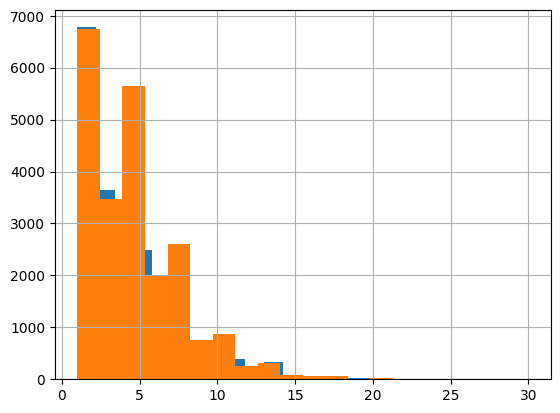

In [14]:
df2.loc[df2['group'] == 'GRP A','purchases'].hist(bins = 20);
df2.loc[df2['group'] == 'GRP B','purchases'].hist(bins = 20);
#Distribuições extremamente parecidas

### 2.3 EDA

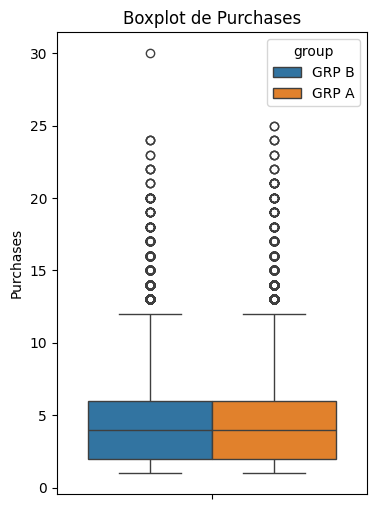

In [20]:
# Criando o boxplot
plt.figure(figsize=(4, 6))
sns.boxplot(y='purchases',  hue='group',data=df2)

# Adicionando títulos e rótulos
plt.title('Boxplot de Purchases')
plt.ylabel('Purchases')

# Exibindo o gráfico
plt.show()

#### 2.3.1 Ditribuição por Country

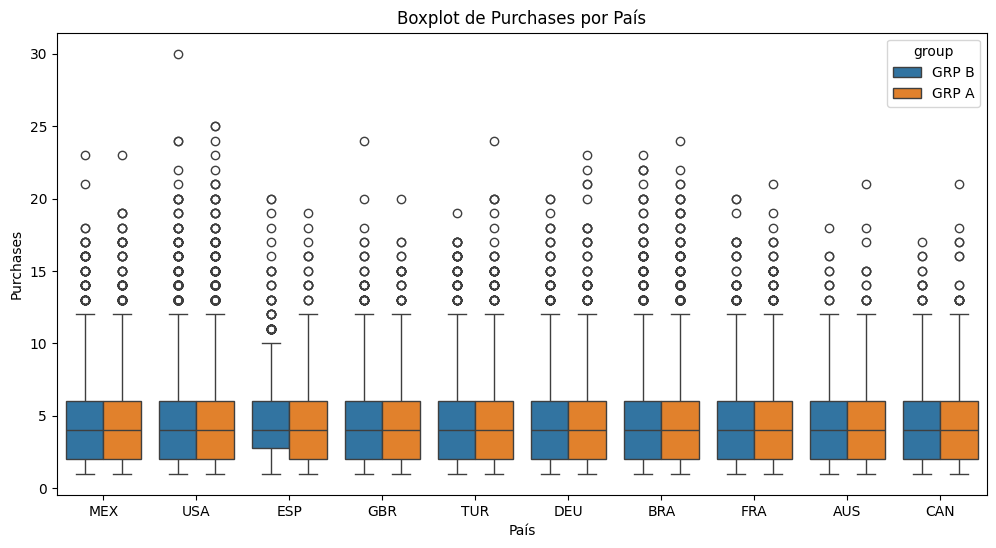

In [21]:
# Criando o boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='purchases',  hue='group',data=df2)

# Adicionando títulos e rótulos
plt.title('Boxplot de Purchases por País')
plt.xlabel('País')
plt.ylabel('Purchases')

# Exibindo o gráfico
plt.show()

#### 2.3.2 Ditribuição por Device

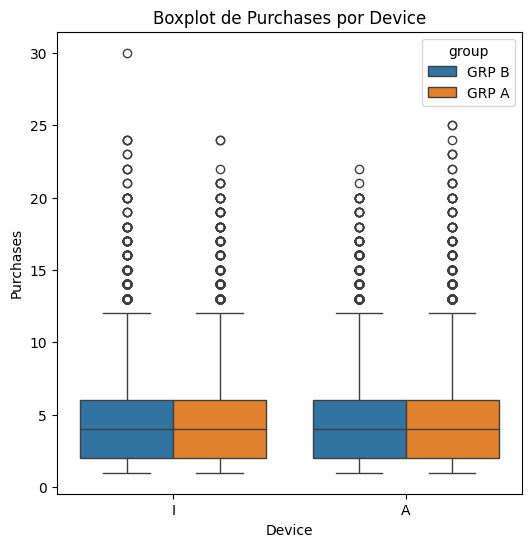

In [19]:
# Criando o boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(x='device', y='purchases',  hue='group',data=df2)

# Adicionando títulos e rótulos
plt.title('Boxplot de Purchases por Device')
plt.xlabel('Device')
plt.ylabel('Purchases')

# Exibindo o gráfico
plt.show()

#### 2.3.3 Ditribuição por Gender

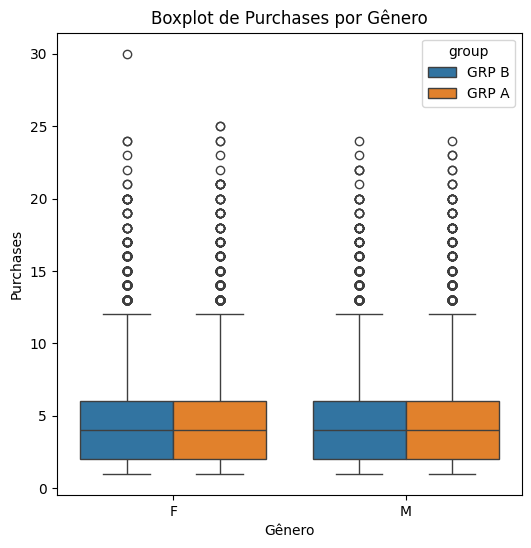

In [18]:
# Criando o boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(x='gender', y='purchases',  hue='group',data=df2)

# Adicionando títulos e rótulos
plt.title('Boxplot de Purchases por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Purchases')

# Exibindo o gráfico
plt.show()

### 2.4 Definir o tamanho da amostra

In [14]:
mean_pop = df2.loc[:,'purchases'].mean()
std_pop = df2.loc[:,'purchases'].std()
print(f'O GMV Médio Total é de: {round(mean_pop,2)} +/- {round(std_pop,2)}')

O GMV Médio Total é de: 4.54 +/- 3.1


In [15]:
lift = 0.05
init_metric = mean_pop
end_metric = init_metric*(1+lift)
std_metric = std_pop

effect_size = (end_metric - init_metric)/std_metric

sample_size = np.ceil(sms.tt_ind_solve_power(
  effect_size = effect_size,
  alpha = 0.05,
  power = 0.8
)).astype(int)

print(sample_size)

2928


## 3.0 Teste de Hipóteses

#### 3.0.1 Condições para o teste estatístico

In [16]:
df_A = df2.loc[df2['group'] == 'GRP A',:]
df_B = df2.loc[df2['group'] == 'GRP B',:]

In [17]:
if (df_A.shape[0] > sample_size) and (df_B.shape[0] > sample_size):
  print(f'Há amostras o suficiente para realizar o teste.')
else:
  print(f'Não há amostras o suficiente para realizar o teste.')

Há amostras o suficiente para realizar o teste.


### 3.1 Groups

In [18]:
sample_A = df2.loc[df2['group'] == 'GRP A','purchases'].sample(n=sample_size,random_state=42)
sample_B = df2.loc[df2['group'] == 'GRP B','purchases'].sample(n=sample_size,random_state=42)

#Métricas
print(f'AVG Sample A: {round(sample_A.mean(),2)} +/- {round(sample_A.std(),2)}')
print(f'AVG Sample B: {round(sample_B.mean(),2)} +/- {round(sample_B.std(),2)}')

AVG Sample A: 4.51 +/- 3.03
AVG Sample B: 4.61 +/- 3.01


### 3.2 Inferência Estatística

In [19]:
z_value,p_value = ttest_ind(sample_A,sample_B)
print(f'p-value: {round(p_value,2)}')

p-value: 0.21


## 4.0 Conclusão

In [20]:
if p_value < 0.05:
  print(f'Rejeita a Hipótese nula')
  print(f'Há uma mudança significativa no GMV médio da página')
  if sample_A.mean() > sample_B.mean():
    print(f'O GMV Médio da página com o preenchimento automático é estatisticamente MAIOR que o GMV Médio da página com o preenchimento manual')
  else:
    print(f'O GMV Médio da página com o preenchimento automático é estatisticamente MENOR que o GMV Médio da página com o preenchimento manual')
else:
  print(f'Falha em rejeitar a hipótese nula')
  print(f'Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página')

Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


In [21]:
#Próximos passos - Criar fazer uma EDA que mostre como os valores são aprecidos e criar uma função por país

## 5.0 Função do Teste de hipóteses

In [22]:
def hip_test(df2,lift,significance_level,power):
  mean_pop = df2.loc[:,'purchases'].mean()
  std_pop = df2.loc[:,'purchases'].std()

  init_metric = mean_pop
  end_metric = init_metric*(1+lift)
  std_metric = std_pop

  effect_size = (end_metric - init_metric)/std_metric

  sample_size = np.ceil(sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = significance_level,
    power = power
  )).astype(int)

  df_A = df2.loc[df2['group'] == 'GRP A',:]
  df_B = df2.loc[df2['group'] == 'GRP B',:]
  print(f'\nPara lift: {lift*100}%')
  if (df_A.shape[0] > sample_size) and (df_B.shape[0] > sample_size):
    print(f'Há amostras o suficiente para realizar o teste.')
    sample_A = df2.loc[df2['group'] == 'GRP A','purchases'].sample(n=sample_size,random_state=42)
    sample_B = df2.loc[df2['group'] == 'GRP B','purchases'].sample(n=sample_size,random_state=42)

    #Métricas
    #print(f'AVG Sample A: {round(sample_A.mean(),2)} +/- {round(sample_A.std(),2)}')
    #print(f'AVG Sample B: {round(sample_B.mean(),2)} +/- {round(sample_B.std(),2)}')

    z_value,p_value = ttest_ind(sample_A,sample_B)
    #print(f'p-value: {round(p_value,2)}')

    if p_value < significance_level:
      print(f'Rejeita a Hipótese nula')
      print(f'Há uma mudança significativa no GMV médio da página')
      if sample_A.mean() > sample_B.mean():
        print(f'O GMV Médio da página com o preenchimento automático é estatisticamente MAIOR que o GMV Médio da página com o preenchimento manual')
      else:
        print(f'O GMV Médio da página com o preenchimento automático é estatisticamente MENOR que o GMV Médio da página com o preenchimento manual')
    else:
      print(f'Falha em rejeitar a hipótese nula')
      print(f'Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página')
  else:
    print(f'Não há amostras o suficiente para realizar o teste.')

In [23]:
hip_test(df2,0.05,0.05,0.8)


Para lift: 5.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


In [24]:
lifts = [0.01,0.05,0.1,0.15,0.2]
for lift in lifts:
  hip_test(df2,lift,0.05,0.8)


Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 10.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 15.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 20.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


Através dos testes podemos dizer que temos evidências para dizer que estatísticamente há diferença de 10% entre o GMV da página com preenchimento automático e com preenchimento manual, mas essa diferença é menor para o preenchimento automático, evidenciando que o novo modo de preechimento não obteve sucesso.

## 6.0 Testando com filtros diferentes

### 6.1 Gênero

In [25]:
df2['gender'].unique()

array(['F', 'M'], dtype=object)

#### 6.1.1 Feminino

In [26]:
df_F = df2.loc[df2['gender'] == 'F',:]
lifts = [0.01,0.05,0.1,0.15,0.2]
for lift in lifts:
  hip_test(df_F,lift,0.05,0.8)


Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 10.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 15.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 20.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


#### 6.1.2 Masculino

In [27]:
df_M = df2.loc[df2['gender'] == 'M',:]
lifts = [0.01,0.05,0.1,0.15,0.2]
for lift in lifts:
  hip_test(df_M,lift,0.05,0.8)


Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 10.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 15.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 20.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


### 6.2 Device

In [28]:
df2['device'].unique()

array(['I', 'A'], dtype=object)

#### 6.2.1 Site

In [29]:
df_I = df2.loc[df2['device'] == 'I',:]
lifts = [0.01,0.05,0.1,0.15,0.2]
for lift in lifts:
  hip_test(df_I,lift,0.05,0.8)


Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 10.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 15.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 20.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


#### 6.2.2 App

In [30]:
df_App = df2.loc[df2['device'] == 'A',:]
lifts = [0.01,0.05,0.1,0.15,0.2]
for lift in lifts:
  hip_test(df_App,lift,0.05,0.8)


Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 10.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 15.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 20.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página


### 6.3 Country

In [31]:
df2['country'].unique()

array(['MEX', 'USA', 'ESP', 'GBR', 'TUR', 'DEU', 'BRA', 'FRA', 'AUS',
       'CAN'], dtype=object)

In [32]:
countries = ['MEX', 'USA', 'ESP', 'GBR', 'TUR', 'DEU', 'BRA', 'FRA', 'AUS','CAN']
for country in countries:
  df_country = df2.loc[df2['country'] == country,:]
  print(f'\nPara o país: {country}:')
  lifts = [0.01,0.05,0.1,0.15,0.2]
  for lift in lifts:
    hip_test(df_country,lift,0.05,0.8)


Para o país: MEX:

Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 10.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 15.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para lift: 20.0%
Há amostras o suficiente para realizar o teste.
Falha em rejeitar a hipótese nula
Não temos evidências suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página

Para o país: USA:

Para lift: 1.0%
Não há amostras o suficiente para realizar o teste.

Para lift: 5.0%
Há amostras o suficiente para realizar o test

In [79]:
#Fazer com o purchases também?